# Reasoning and Decision Making under Uncertainty
# Portfolio 2 - Sensor Fusion

**Name:  Aniket Dattatraya Kulkarni**

**Matriculation Number: 5123739**

**Email ID: aniketdattatraya.kulkarni@study.thws.de**

## Task P2.2: Particle Filter

### Realize an implementation of the Particle Filter in a programming language of your choice for a simulation of the ball-throwing example from the lecture slides. The task of your Particle Filter is to estimate the positions and velo city vectors of two balls flying simultaneously only from the observed erroneous positions over time.

Your implementation shall flexible in the sense that it can handle variations similar to the ones from Task P2.1. In addition, you need to consider how to deal with more than one ball flying at the same time. How do you estimate two positions from the density? How do you define your state?
 
Note: There is more than one good approach here. Thus, there is no clear b est solution approach in this task.

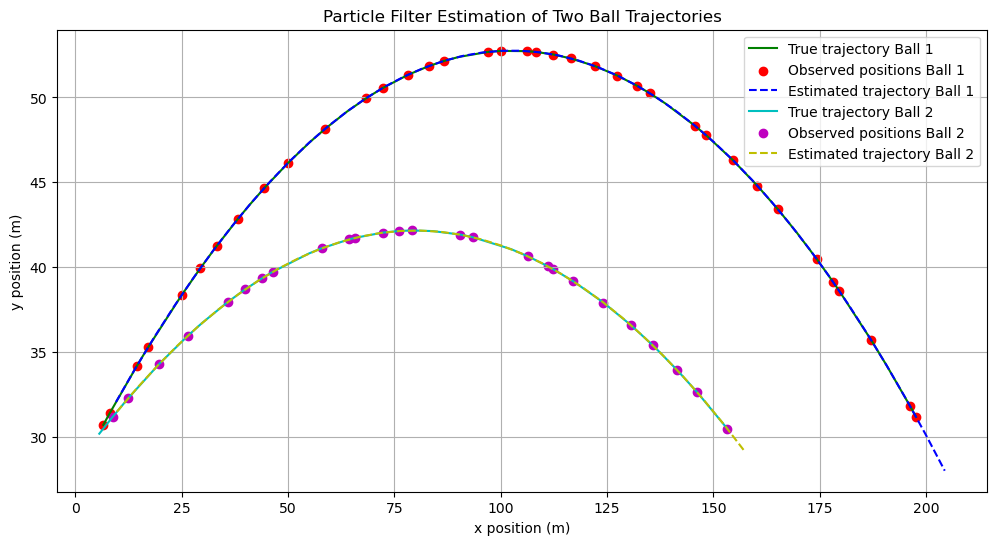

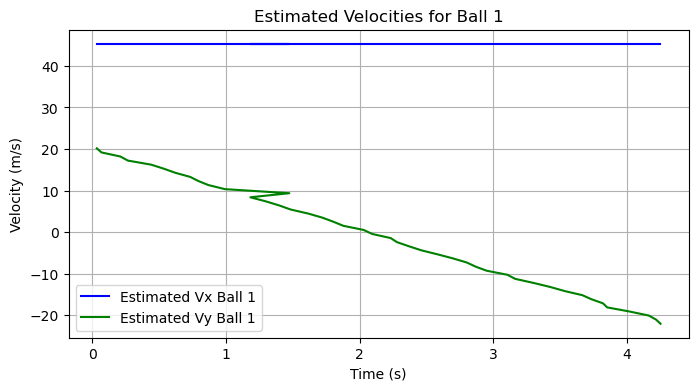

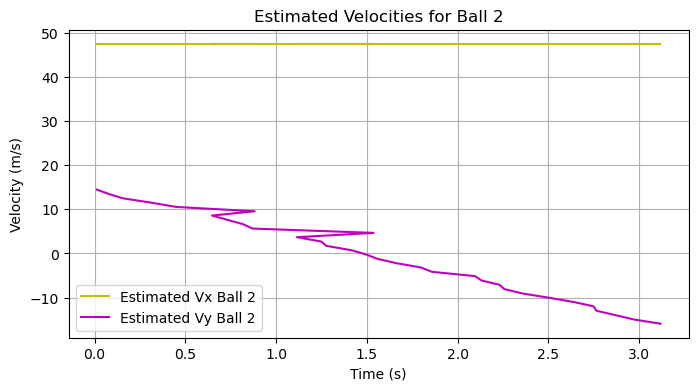

Launch Speed for Ball 1: 50 m/s
Launch Angle for Ball 1: 25 degrees
Launch Height for Ball 1: 30 m
Launch Speed for Ball 2: 50 m/s
Launch Angle for Ball 2: 18 degrees
Launch Height for Ball 2: 30 m
Measurement Noise Standard Deviation: 0.01 m
Dropout Probability: 0.1
MSE for Ball 1: 11.612
RMSE for Ball 1: 3.408
MSE for Ball 2: 12.540
RMSE for Ball 2: 3.541


In [29]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

# Configuration for the simulation parameters
config = {
    "ball1": {"init_x": 5, "init_y": 30, "init_speed": 50, "init_angle": 25},
    "ball2": {"init_x": 5, "init_y": 30, "init_speed": 50, "init_angle": 18},
    "simulation": {
        "gravity": 9.81,
        "num_particles": 100,
        "position_uncertainty": 0.01,
        "time_step": 0.1,
        "dropout_probability": 0.1,
        "max_gap_length": 0.5  # Maximum duration for complete dropout periods
    }
}

# Extracting parameters from the configuration
init_x0, init_y0, init_speed0, init_angle0 = config["ball1"].values()
init_x1, init_y1, init_speed1, init_angle1 = config["ball2"].values()
gravity, num_particles, position_uncertainty, time_step, dropout_probability, max_gap_length = config["simulation"].values()

angle0_rad = np.radians(init_angle0)
angle1_rad = np.radians(init_angle1)

class ParticleFilter:
    def __init__(self, num_particles, initial_state, process_noise, measurement_noise):
        self.num_particles = num_particles
        self.particles = np.empty((num_particles, len(initial_state)))
        self.weights = np.ones(num_particles) / num_particles
        self.process_noise = process_noise
        self.measurement_noise = measurement_noise
        self._initialize_particles(initial_state)

    def _initialize_particles(self, initial_state):
        # Initialize particles around the initial state with process noise
        for i in range(0, len(initial_state), 4):
            self.particles[:, i] = initial_state[i] + np.random.normal(0, self.process_noise[i], size=self.num_particles)
            self.particles[:, i+1] = initial_state[i+1] + np.random.normal(0, self.process_noise[i+1], size=self.num_particles)
            self.particles[:, i+2] = initial_state[i+2]
            self.particles[:, i+3] = initial_state[i+3]

    def predict(self):
        # Predict the next state of each particle based on the motion model
        for i in range(0, self.particles.shape[1], 4):
            self.particles[:, i] += self.particles[:, i+2] * time_step
            self.particles[:, i+1] += self.particles[:, i+3] * time_step - 0.5 * gravity * time_step**2
            self.particles[:, i+3] -= gravity * time_step

    def update_weights(self, measurement):
        # Update the weights of each particle based on the measurement likelihood
        for i in range(0, len(measurement), 2):
            if not np.isnan(measurement[i]):
                dist_sq = (self.particles[:, i:i+2] - measurement[i//2]) ** 2
                self.weights *= np.exp(-0.5 * np.sum(dist_sq / self.measurement_noise**2, axis=1))
        self.weights += 1.e-300  # Avoid zero weights
        self.weights /= np.sum(self.weights)  # Normalize

    def resample(self):
        # Resample particles based on their weights to focus on high-probability regions
        indices = np.random.choice(range(self.num_particles), self.num_particles, p=self.weights)
        self.particles = self.particles[indices]
        self.weights.fill(1.0 / self.num_particles)

    def estimate_state(self):
        # Estimate the state as the weighted average of the particles
        return np.average(self.particles, weights=self.weights, axis=0)

    def estimate_velocity(self):
        # Estimate the velocities as the weighted average of the particle velocities
        return np.average(self.particles[:, [2, 3, 6, 7]], weights=self.weights, axis=0)

# Calculate the time of flight for both balls
flight_time0 = 2 * init_speed0 * np.sin(angle0_rad) / gravity
flight_time1 = 2 * init_speed1 * np.sin(angle1_rad) / gravity

# Generate variable time steps
time_steps0 = np.arange(0, flight_time0, time_step)
time_steps1 = np.arange(0, flight_time1, time_step)

# Introduce variability in time steps
time_steps0 = time_steps0 + np.random.uniform(-0.05, 0.05, size=time_steps0.shape)
time_steps1 = time_steps1 + np.random.uniform(-0.05, 0.05, size=time_steps1.shape)

# Generate true and observed positions with added noise
true_positions0_x = init_x0 + init_speed0 * np.cos(angle0_rad) * time_steps0
true_positions0_y = init_y0 + init_speed0 * np.sin(angle0_rad) * time_steps0 - 0.5 * gravity * time_steps0**2
observed_positions0 = np.column_stack((true_positions0_x, true_positions0_y)) + np.random.normal(0, position_uncertainty, size=(len(time_steps0), 2))

true_positions1_x = init_x1 + init_speed1 * np.cos(angle1_rad) * time_steps1
true_positions1_y = init_y1 + init_speed1 * np.sin(angle1_rad) * time_steps1 - 0.5 * gravity * time_steps1**2
observed_positions1 = np.column_stack((true_positions1_x, true_positions1_y)) + np.random.normal(0, position_uncertainty, size=(len(time_steps1), 2))

# Introduce random measurement dropouts
for i in range(len(observed_positions0)):
    if np.random.rand() < dropout_probability:
        observed_positions0[i] = [np.nan, np.nan]
    if i > 0 and np.random.rand() < dropout_probability:
        gap_length = np.random.uniform(0, max_gap_length)
        observed_positions0[i] = [np.nan, np.nan]
        time_steps0[i] += gap_length

for i in range(len(observed_positions1)):
    if np.random.rand() < dropout_probability:
        observed_positions1[i] = [np.nan, np.nan]
    if i > 0 and np.random.rand() < dropout_probability:
        gap_length = np.random.uniform(0, max_gap_length)
        observed_positions1[i] = [np.nan, np.nan]
        time_steps1[i] += gap_length

# Define initial states and noise parameters
initial_state = [
    init_x0, init_y0, init_speed0 * np.cos(angle0_rad), init_speed0 * np.sin(angle0_rad),
    init_x1, init_y1, init_speed1 * np.cos(angle1_rad), init_speed1 * np.sin(angle1_rad)
]
process_noise = [position_uncertainty, position_uncertainty, 0, 0, position_uncertainty, position_uncertainty, 0, 0]
measurement_noise = position_uncertainty

# Create a Particle Filter instance
pf = ParticleFilter(num_particles, initial_state, process_noise, measurement_noise)

# Arrays to store estimated positions and velocities
estimated_positions0 = np.full((len(time_steps0), 2), np.nan)
estimated_velocities0 = np.zeros((len(time_steps0), 2))
estimated_positions1 = np.full((len(time_steps1), 2), np.nan)
estimated_velocities1 = np.zeros((len(time_steps1), 2))

# Run the Particle Filter for each time step
for t in range(max(len(time_steps0), len(time_steps1))):
    pf.predict()
    if t < len(time_steps0):
        pf.update_weights(observed_positions0[t])
        pf.resample()
        state_estimate = pf.estimate_state()
        estimated_positions0[t] = state_estimate[:2]
        estimated_velocities0[t] = state_estimate[2:4]
    if t < len(time_steps1):
        pf.update_weights(observed_positions1[t])
        pf.resample()
        state_estimate = pf.estimate_state()
        estimated_positions1[t] = state_estimate[4:6]
        estimated_velocities1[t] = state_estimate[6:8]

# Function to calculate RMSE
def calculate_rmse(true_values, estimated_values):
    mask = ~np.isnan(true_values)
    return np.sqrt(mean_squared_error(true_values[mask], estimated_values[mask]))

# Calculate MSE and RMSE for both balls
valid_idx0 = ~np.isnan(observed_positions0).any(axis=1)
valid_idx1 = ~np.isnan(observed_positions1).any(axis=1)

mse0 = mean_squared_error(observed_positions0[valid_idx0], estimated_positions0[valid_idx0])
rmse0 = calculate_rmse(observed_positions0[valid_idx0], estimated_positions0[valid_idx0])

mse1 = mean_squared_error(observed_positions1[valid_idx1], estimated_positions1[valid_idx1])
rmse1 = calculate_rmse(observed_positions1[valid_idx1], estimated_positions1[valid_idx1])

# Plotting the true and estimated trajectories
plt.figure(figsize=(12, 6))
plt.plot(true_positions0_x, true_positions0_y, 'g-', label='True trajectory Ball 1')
plt.scatter(observed_positions0[:, 0], observed_positions0[:, 1], c='r', label='Observed positions Ball 1')
plt.plot(estimated_positions0[:, 0], estimated_positions0[:, 1], 'b--', label='Estimated trajectory Ball 1')

plt.plot(true_positions1_x, true_positions1_y, 'c-', label='True trajectory Ball 2')
plt.scatter(observed_positions1[:, 0], observed_positions1[:, 1], c='m', label='Observed positions Ball 2')
plt.plot(estimated_positions1[:, 0], estimated_positions1[:, 1], 'y--', label='Estimated trajectory Ball 2')

plt.xlabel('x position (m)')
plt.ylabel('y position (m)')
plt.title('Particle Filter Estimation of Two Ball Trajectories')
plt.legend()
plt.grid(True)
plt.show()

# Plot estimated velocities for Ball 1
plt.figure(figsize=(8, 4))
plt.plot(time_steps0, estimated_velocities0[:, 0], 'b-', label='Estimated Vx Ball 1')
plt.plot(time_steps0, estimated_velocities0[:, 1], 'g-', label='Estimated Vy Ball 1')
plt.xlabel('Time (s)')
plt.ylabel('Velocity (m/s)')
plt.title('Estimated Velocities for Ball 1')
plt.legend()
plt.grid(True)
plt.show()

# Plot estimated velocities for Ball 2
plt.figure(figsize=(8, 4))
plt.plot(time_steps1, estimated_velocities1[:, 0], 'y-', label='Estimated Vx Ball 2')
plt.plot(time_steps1, estimated_velocities1[:, 1], 'm-', label='Estimated Vy Ball 2')
plt.xlabel('Time (s)')
plt.ylabel('Velocity (m/s)')
plt.title('Estimated Velocities for Ball 2')
plt.legend()
plt.grid(True)
plt.show()

# Print important information
print(f"Launch Speed for Ball 1: {init_speed0} m/s")
print(f"Launch Angle for Ball 1: {init_angle0} degrees")
print(f"Launch Height for Ball 1: {init_y0} m")
print(f"Launch Speed for Ball 2: {init_speed1} m/s")
print(f"Launch Angle for Ball 2: {init_angle1} degrees")
print(f"Launch Height for Ball 2: {init_y1} m")
print(f"Measurement Noise Standard Deviation: {position_uncertainty} m")
print(f"Dropout Probability: {dropout_probability}")
print(f"MSE for Ball 1: {mse0:.3f}")
print(f"RMSE for Ball 1: {rmse0:.3f}")
print(f"MSE for Ball 2: {mse1:.3f}")
print(f"RMSE for Ball 2: {rmse1:.3f}")
